In [1]:
import pywt
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense , Input , LSTM, Bidirectional, Dropout
from tensorflow.keras.models import Model , Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
#from utility_function import autoencoder

In [2]:
def wavelet_transform(df):
    ca , cb, cc , cd = pywt.wavedec(df['price'].values, 'haar', level = 3)
    cat = pywt.threshold(ca, np.std(ca), mode = 'soft')
    cbt = pywt.threshold(cb, np.std(cb), mode = 'soft')
    cct = pywt.threshold(cc, np.std(cc), mode = 'soft')
    cdt = pywt.threshold(cd, np.std(cd), mode = 'soft')
    coeff = [cat , cbt, cct , cdt]
    return pywt.waverec(coeff, 'haar')

def get_sample(df, length, temporal_horizon):

    temporal_horizon = temporal_horizon - 1
    last_possible = df.shape[0] - temporal_horizon - length
    random_start = np.random.randint(0, last_possible)
    X_sample = df.drop(columns = 'price')[random_start: random_start+length].values
    y_sample = df['price'][random_start+length: random_start+length+temporal_horizon+1]
    
   # if y_sample != y_sample:
        #X_sample, y_sample = get_sample(df, length, temporal_horizon)
    
    return X_sample, y_sample

def get_X_y(df, temporal_horizon, length_of_sequences):
    X, y = [], []

    for len_ in length_of_sequences:
        xi, yi = get_sample(df, len_, temporal_horizon)
        X.append(xi)
        y.append(yi)
        
    return X, np.array(y)


def autoencoder(features):
    input_data = Input(shape=(1, features))
    encoded1 = Dense(features, activation="relu", activity_regularizer=regularizers.l2(0))(input_data)
    one_l = Dense(1, activation="relu", activity_regularizer=regularizers.l2(0))(encoded1)
    decoded = Dense(features, activation="linear", activity_regularizer=regularizers.l2(0))(one_l)
    autoencoder = Model(inputs=input_data, outputs=decoded)
    encoder = Model(input_data, one_l)
    autoencoder.compile(loss = 'mse', optimizer = 'rmsprop',metrics = ['mae'])
    return autoencoder , encoder

def init_model() :
    model = Sequential()               
    model.add(LSTM(150,activation = 'tanh',input_shape=(length, 14),return_sequences = True))
    model.add(Dropout(0.5))  
    model.add(Bidirectional(LSTM(120, activation = 'tanh',return_sequences=True)))
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(100,activation = 'tanh',return_sequences = True)))
    model.add(Dropout(0.5))
    model.add(LSTM(80,activation = 'tanh'))
    model.add(Dense(60,activation = 'relu'))     
    model.add(Dense(n_days,activation = 'linear'))

    model.compile(loss = 'mse', optimizer = 'rmsprop',metrics = ['mae'])

    return model

def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Mean Square Error - Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()
    
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title('Model loss')
    plt.ylabel('Mean Absolute Error')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()
    
def get_prediction(df_test,length, period_test):
    df_test_n = df_test.copy()
    df_test_n['price'] = wavelet_transform(df_test_n)[:len(df_test_n)]

    df_test = df_test[length:]

    prediction = []
    for x in range(len(df_test)):
        encode = autoencoder.predict(df_test_n[x:x+length])
        encode.shape = (1,encode.shape[0], encode.shape[1])
        predict = model.predict(encode)
        prediction.append(predict)

    prediction = np.array(prediction)
    prediction.shape = (period_test)

    return prediction



## DATA

In [23]:
df  = pd.read_csv('ma_ema.csv')
df.set_index('date', inplace = True)
df_test = df[2970:3361]
df = df[:3000]

In [4]:
df['price'] = wavelet_transform(df)
df.dropna(inplace = True)

## AUTOENCODER

In [5]:
autoencoder,encoder = autoencoder(14)

In [6]:
X = np.array(df)
X = X.reshape(len(X), 1, 14)

In [7]:
es = EarlyStopping(monitor = 'val_loss',mode = 'min' , verbose = 1, patience = 20, restore_best_weights = True)
history = autoencoder.fit(X,X,
                    validation_split = 0.3,
                   callbacks = [es], 
                   epochs = 1000, 
                   batch_size = 64,
                   shuffle = True)

Epoch 1/1000
32/32 [==============================] - 0s 7ms/step - loss: 0.0089 - mae: 0.0492 - val_loss: 0.0137 - val_mae: 0.0580
Epoch 2/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0075 - mae: 0.0453 - val_loss: 0.0112 - val_mae: 0.0549
Epoch 3/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0069 - mae: 0.0442 - val_loss: 0.0097 - val_mae: 0.0527
Epoch 4/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0066 - mae: 0.0442 - val_loss: 0.0091 - val_mae: 0.0522
Epoch 5/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0065 - mae: 0.0437 - val_loss: 0.0090 - val_mae: 0.0519
Epoch 6/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.0064 - mae: 0.0428 - val_loss: 0.0088 - val_mae: 0.0500
Epoch 7/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0062 - mae: 0.0421 - val_loss: 0.0087 - val_mae: 0.0495
Epoch 8/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.

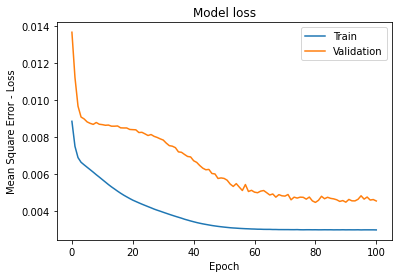

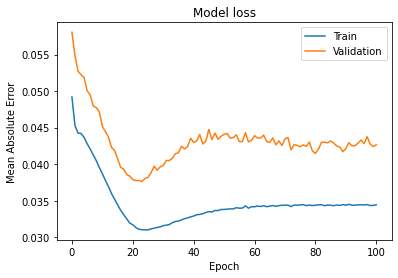

In [8]:
plot_loss(history)

In [9]:
X_encode = autoencoder.predict(X)
X_encode.shape = (X_encode.shape[0], X_encode.shape[2])
new_df = pd.DataFrame(X_encode)
df.reset_index(inplace = True)
new_df['price'] = df['price']

In [10]:
n_days = 30
length = 30
length_of_sequences = [length for x in range(3500)]

X_train, y_train = get_X_y(new_df, n_days, length_of_sequences)

In [11]:
from tensorflow.keras.callbacks import EarlyStopping
model = init_model()
es = EarlyStopping(monitor = 'val_loss',mode = 'min' , verbose = 1, patience = 20, restore_best_weights = True)
history = model.fit(np.array(X_train), y_train,
                    validation_split = 0.3,
                   callbacks = [es], 
                   epochs = 1000, 
                   batch_size = 32)
                   shuffle = True)

Epoch 1/1000
77/77 [==============================] - 7s 97ms/step - loss: 0.0259 - mae: 0.1135 - val_loss: 0.0159 - val_mae: 0.1003
Epoch 2/1000
77/77 [==============================] - 6s 72ms/step - loss: 0.0144 - mae: 0.0928 - val_loss: 0.0140 - val_mae: 0.0951
Epoch 3/1000
77/77 [==============================] - 6s 75ms/step - loss: 0.0133 - mae: 0.0889 - val_loss: 0.0121 - val_mae: 0.0845
Epoch 4/1000
77/77 [==============================] - 6s 71ms/step - loss: 0.0122 - mae: 0.0835 - val_loss: 0.0135 - val_mae: 0.0921
Epoch 5/1000
77/77 [==============================] - 6s 73ms/step - loss: 0.0116 - mae: 0.0803 - val_loss: 0.0142 - val_mae: 0.0889
Epoch 6/1000
77/77 [==============================] - 6s 73ms/step - loss: 0.0108 - mae: 0.0776 - val_loss: 0.0096 - val_mae: 0.0748
Epoch 7/1000
77/77 [==============================] - 6s 73ms/step - loss: 0.0105 - mae: 0.0762 - val_loss: 0.0100 - val_mae: 0.0742
Epoch 8/1000
77/77 [==============================] - 6s 72ms/step - 

Epoch 122/1000
77/77 [==============================] - 6s 74ms/step - loss: 7.7875e-04 - mae: 0.0169 - val_loss: 8.9184e-04 - val_mae: 0.0180
Epoch 123/1000
77/77 [==============================] - 5s 71ms/step - loss: 8.5139e-04 - mae: 0.0175 - val_loss: 8.6071e-04 - val_mae: 0.0177
Epoch 124/1000
77/77 [==============================] - 5s 71ms/step - loss: 7.7536e-04 - mae: 0.0173 - val_loss: 8.9598e-04 - val_mae: 0.0173
Epoch 125/1000
77/77 [==============================] - 6s 73ms/step - loss: 7.8785e-04 - mae: 0.0172 - val_loss: 8.1152e-04 - val_mae: 0.0173
Epoch 126/1000
77/77 [==============================] - 6s 73ms/step - loss: 7.2934e-04 - mae: 0.0169 - val_loss: 0.0012 - val_mae: 0.0218
Epoch 127/1000
77/77 [==============================] - 5s 71ms/step - loss: 6.7810e-04 - mae: 0.0166 - val_loss: 7.7986e-04 - val_mae: 0.0162
Epoch 128/1000
77/77 [==============================] - 6s 72ms/step - loss: 6.7469e-04 - mae: 0.0165 - val_loss: 0.0011 - val_mae: 0.0196
Epoch 1

In [85]:
X_sample = df.drop(columns = 'price').loc[random_start: random_start+length].values
y_sample = df['price'].loc[random_start+length: random_start+length+temporal_horizon+1].values

array([0.70279414, 0.6955489 , 0.69917152, 0.69917152, 0.69635148,
       0.69635148, 0.69264705, 0.70122797, 0.70247065, 0.70247065,
       0.70247065, 0.70247065, 0.71979751, 0.71979751, 0.71979751,
       0.71979751, 0.68335582, 0.68335582, 0.67305959, 0.67305959,
       0.63588991, 0.63588991, 0.61870003, 0.61870003, 0.60274546,
       0.60274546, 0.61159158, 0.58536878, 0.45934064, 0.52179362])

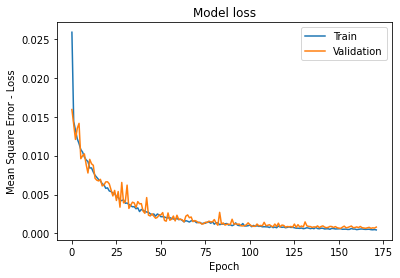

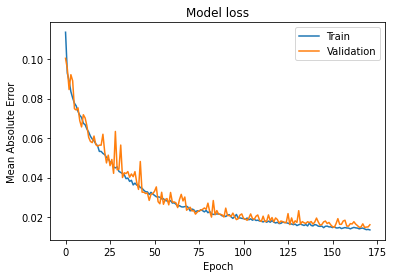

In [12]:
plot_loss(history)

## TEST

In [24]:
def get_prediction(df_test,length):
    df_test_n = df_test.copy()
    df_test_n['price'] = wavelet_transform(df_test_n)[:len(df_test_n)]

    df_test = df_test[length + 1:]

    prediction = []
    for x in range(len(df_test)):
        encode = autoencoder.predict(df_test_n[x:x+length])
        encode.shape = (1,encode.shape[0], encode.shape[1])
        predict = model.predict(encode)
        prediction.append(predict)
    return prediction

In [25]:
prediction = np.array(prediction)
prediction.shape = (360)

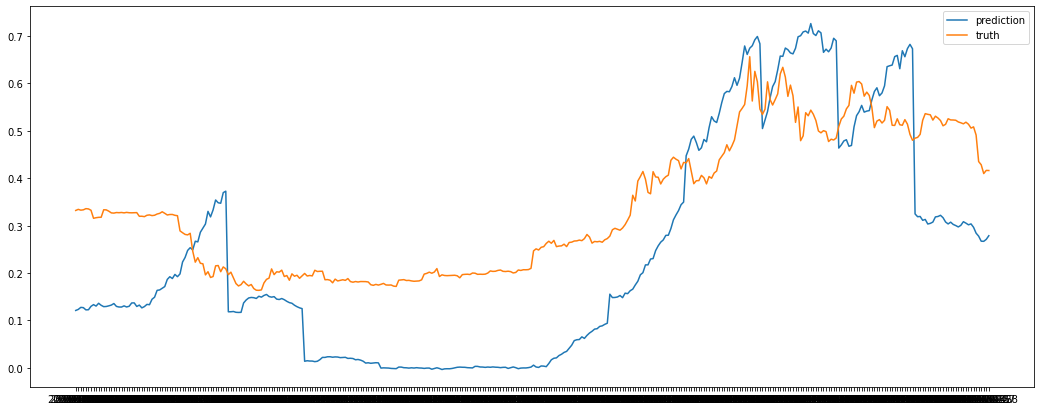

In [26]:
plt.figure(figsize = (18, 7))
plt.plot(prediction, label = 'prediction')
plt.plot(df_test['price'], label = 'truth')
plt.legend()

In [131]:
df = df_test[['price']]
df['prediction'] = prediction
df.columns  = ['true', 'prediction']
long = []
for i in range(len(df)-1):
    if df['prediction'].iloc[i+1] > df['prediction'].iloc[i] : 
        long.append(1)
    else : 
        long.append(0)
long.append(0)
df['long'] = long      

ValueError: Length of values (360) does not match length of index (391)

In [129]:
perf = [0]
for i in range(len(df)-1):
    if df['long'].iloc[i-1] == 1 : 
        x = (df['true'].iloc[i] - df['true'].iloc[i-1]) / df['true'].iloc[i-1]
        perf.append(1 + x)
    else : 
        x = (df['true'].iloc[i-1] - df['true'].iloc[i]) / df['true'].iloc[i-1]
        perf.append(1 + x)
df['perf'] = perf

KeyError: 'long'

In [161]:
df  = pd.read_csv('ma_ema.csv').set_index('date').dropna()

In [167]:
df['price'].count()

3637